# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💾 The data
The team assembled the following file:

#### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


In [92]:
def get_pvalue(con_conv, test_conv, con_size, test_size):  
    lift =  - abs(test_conv - con_conv)

    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

def get_ci(value, cl, sd):
  loc = stats.norm.ppf(1 - cl/2)
  rng_val = stats.norm.cdf(loc - value/sd)

  lwr_bnd = value - rng_val
  upr_bnd = value + rng_val 

  return_val = (lwr_bnd, upr_bnd)
  return(return_val)

In [81]:
df = pd.read_csv('data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [91]:
# Create a grouping variable
df['group'] = "Control"
df.loc[(df.treatment == "yes") & (df.new_images == "no"), "group"] = "New Landing Page"
df.loc[(df.treatment == "no") & (df.new_images == "yes"), "group"] = "New Images"
df.loc[(df.treatment == "yes") & (df.new_images == "yes"), "group"] = "Both"
df['group'].value_counts()

Both                10121
New Landing Page    10121
New Images          10121
Control             10121
Name: group, dtype: int64

In [132]:
test = df.groupby(['group'])[['converted']].mean()
control = test.loc[test.index.get_level_values('group') == "Control", 'converted'].values
p = []
for idx, row in test.iterrows():
    p.append(get_pvalue(control, row['converted'], 10121, 10121))
test['p'] = [round(float(x), 3) for x in p]
test['result'] = 'not significant'
test.loc[test.p <= .05, 'result'] = 'significant'
test

,converted,p,result
group,,,
Both,0.113724,0.133,not significant
Control,0.107104,1.000,not significant
New Images,0.112538,0.216,not significant
New Landing Page,0.120047,0.004,significant


The data looks good, we have an equal sample size for the four groups which will make comparing the groups simpler.

The next step is to use the **Binomial proportion confidence interval** to determine the success rates based on the different enhancements.  TO determine the confidence interval of each group, the following formula will be used:  
$p ± z \sqrt{\frac{(1-p)}n}$ 

In [28]:
z = 1.96
test = df.groupby(['group'])[['converted']].mean()
test.columns = ["p"]
test['n'] = df['group'].value_counts()

lcl = []
ucl = []
for idx, row in test.iterrows():
    lcl.append(row['p'] - z * np.sqrt((row['p']*(1 - row['p']))/row['n']))
    ucl.append(row['p'] + z * np.sqrt((row['p']*(1 - row['p']))/row['n']))

test['lcl'] = lcl
test['ucl'] = ucl
test

,p,n,lcl,ucl
group,,,,
Both,0.113724,10121,0.107539,0.119909
Control,0.107104,10121,0.101079,0.113129
New Images,0.112538,10121,0.106381,0.118695
New Landing Page,0.120047,10121,0.113715,0.126380


The **New Landing Page** has a significant impact compared to the **Control**.  There's an interesting observation where the  **New Images** appears to fix the improvement from 10.7% to 11.3% decreasing the improved conversion rate with just a new landing page.  
Lets visualize these results to make it clearer what's happening.  
Using an *Interval Plot* we can visualize any significant differneces.  The tabulated data is using a 95% confidence interval which may be a bit conservative for A/B Testing.  The Interval Plot will use an 80% Confidence Interval.

C:\Users\andre\AppData\Local\Temp/ipykernel_2268/226051898.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100])


Text(0.5, 1.0, 'Conversions from Website Enhancements')

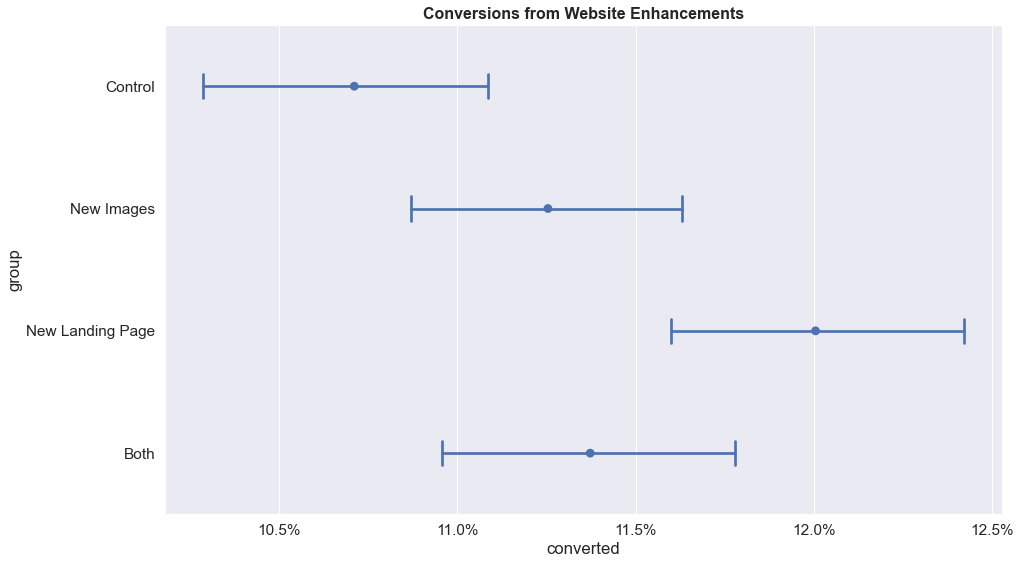

In [76]:
fig, ax = plt.subplots()
sns.set(
    font_scale=1.4
)
fig.set_size_inches([15,9])
ax = sns.pointplot(
    y = "group",
    x = "converted",
    data = df,
    join = False,
    order=["Control", "New Images", "New Landing Page", "Both"],
    ci = 80,
    capsize=.2,
    estimator=np.mean
)
ax.set_xticklabels(['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100])
ax.set_title(
    "Conversions from Website Enhancements",
    fontsize = 16, 
    fontweight = 'bold'
)

The Interval Plot shows a confirmation to what was tabulated.  There's a significant difference between using a New Landing Page and the Control.  It appears the New Landing Page is better left without images, but we don't have the same level of confidence in that statement as we do saying a new Landing Page will improve conversion rate.  
Another interesting look is to create a heatmap of this visualization.

Text(0.5, 44.5, 'New Images')

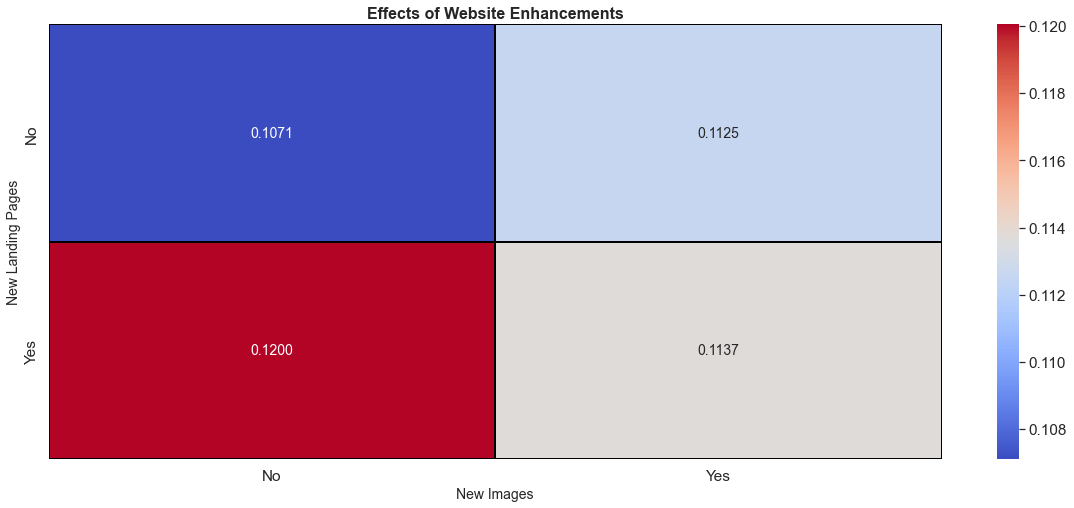

In [72]:
plt.figure(figsize = (20,8))
sns.set(
    font_scale=1.4, 
    rc={"lines.linewidth": 3}
)

sns.heatmap(
    df.pivot_table(
        index =['treatment'],
        columns=['new_images'],
        values =['converted'],
        aggfunc ='mean'        
    ),
    fmt = '0.4f',
    annot=True,
    annot_kws={"size": 14},
    cmap = 'coolwarm',
    linewidths=0.2, 
    linecolor='black',
    xticklabels = ['No', 'Yes'],
    yticklabels = ['No', 'Yes']
    ) 

plt.title(
    'Effects of Website Enhancements', 
    fontsize = 16, 
    fontweight = 'bold'
)
plt.ylabel(
    'New Landing Pages', 
    fontsize = 14
)
plt.xlabel(
    'New Images', 
    fontsize = 14
)


The Heatmap tells the same story we're used to.  Adding new images seems to fix the improced conversion rate whereas leaving the old images and using a New Landing Page has a significant increase conversion rate. 